# Surplux Solar Energy Analysis


## Import Package


In [62]:
import os
import math
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [63]:
SEED = 5397
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

## Helper Functions


Before we write the code for adjusting the models, lets define a few helper functions.


In [64]:
# Processing of data provided by the organizer 
def data_preprocessing(data):
    data['Date'] = pd.to_datetime(data['Date']) # 時間欄位轉換
    # 1 kwh = 3.6 MJ
    # 1 MJ to kwh = 0.27778 kwh
    data['Irradiance'] = data['Irradiance'] / 3.6  # Irradiance 是太陽輻射量 # 將單位從 MJ（百萬焦耳） 轉換為 kWh
    data['Irradiance_m'] = data['Irradiance_m'] / 1000  # Irradiance_m 為輻射功率密度 # 將單位從 W/m² 轉為 kW/m²
    # Capacity Factor compare the power generation efficiency between plants of different scale.  
    data['CapacityFactor'] = data['Generation']/data['Capacity'] # CapacityFactor（容量因子）＝ 實際發電量 / 裝置容量
    # Array Ratio compares the energy collected through the system to the total system load by dividing energy in by energy-out. 
    data['ArrayRatio'] = data['CapacityFactor']/data['Irradiance']  # ArrayRatio（陣列轉換率）＝ 容量因子 / 輻射能量，代表轉換效率
    data['ArrayRatio_m'] = data['CapacityFactor']/data['Irradiance_m'] # 陣列轉換效率 (使用 W/m²)
    return data

## Const & Inputs


Here are all of the parameters to change for the run.


In [65]:
# Top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
path = "."

## Data Description


| 欄位名稱     | 欄位說明                                             |
| ------------ | ---------------------------------------------------- |
| ID           | 資料編號                                             |
| Date         | 資料日期                                             |
| Temp         | 當日平均氣溫(°C)\[2\]                                |
| Temp_m       | 模溫計：模板溫度(°C)\[1\]                            |
| Irradiance   | 日射量(MJ/m²)\[2\]                                   |
| Irradiance_m | 日照計：日射量(Wh/m²)\[1\]                           |
| Generation   | 預測目標 - 發電量(kWh)                               |
| Capacity     | 裝置容量(kWp)                                        |
| Lat          | 緯度                                                 |
| Lon          | 經度                                                 |
| Angle        | 面向角度(0 為正南方，正值為偏向西方，負值為偏向東方) |
| Module       | 模組型號\[3\]                                        |


|                | MM60-6RT-300 | SEC-6M-60A-295 | AUO PM060MW3 320W | AUO PM060MW3 325W |
| -------------- | ------------ | -------------- | ----------------- | ----------------- |
| 峰值輸出(Pmax) | 300W         | 295W           | 320W              | 325W              |
| 峰值電壓(Vmp)  | 32.61        | 31.6           | 33.48             | 33.66             |
| 峰值電流(Imp)  | 9.2          | 9.34           | 9.56              | 9.66              |
| 開路電壓(Voc)  | 38.97        | 39.4           | 40.9              | 41.1              |
| 短路電流(Isc)  | 9.68         | 9.85           | 10.24             | 10.35             |
| 模組效能(%)    | 18.44%       | 17.74%         | 19.2%             | 19.5%             |


## Data Observation


- 觀察到 Temp_m 的缺值較多，是否僅發生在特定模組？ -> 只有 AUO 型號的模組有 Temp_m 屬性
- 觀察到 Irradiance 與 Temp 有約 20 筆缺值，觀察缺值發生的時間點？ -> 缺值通常連續發生，用線性補值效果可能不好
- 觀察到 Irradiance 與 Irradiance_m 平均值差距大，是否為離群值的影響？ -> 有 2 個案場的 Irradiance_m 直接用 Irradiance 補值
- 觀察到 Array Ratio 的平均值為 0.84 -> 符合普遍標準


In [66]:
train = pd.read_csv(os.path.join(path, 'data/train.csv'))
train = data_preprocessing(train)
train[['Temp', 'Temp_m', 'Irradiance', 'Irradiance_m', 'Generation', 'Capacity', 'CapacityFactor', 'ArrayRatio', 'ArrayRatio_m']].describe()

Temp       Temp_m   Irradiance  Irradiance_m   Generation  \
count  3569.000000  2126.000000  3560.000000   3584.000000  3584.000000   
mean     25.722808    42.596990     4.796601    123.770042  1339.483817   
std       5.341206    10.953377     1.894333    160.183435   796.698529   
min       6.900000    11.800000     0.036111      0.000000    17.000000   
25%      22.000000    34.000000     3.658333      5.367000   575.000000   
50%      28.200000    42.500000     5.213889     66.689500  1268.000000   
75%      30.000000    51.700000     6.247917    171.738500  1957.000000   
max      32.500000    68.500000     8.005556   1026.617000  6752.000000   

          Capacity  CapacityFactor   ArrayRatio  ArrayRatio_m  
count  3584.000000     3584.000000  3560.000000   3584.000000  
mean    350.535039        3.887639     0.848853           inf  
std     144.498892        1.538227     0.716940           NaN  
min      99.200000        0.077572     0.016551      0.000423  
25%     246.400000        2.992530     0.755726      0.018646  
50%     352.000000        4.293808     0.816619      0.053874  
75%     498.560000        5.039212     0.886738      0.773430  
max     499.800000       21.443089    30.141287           inf

In [67]:
test = pd.read_csv(os.path.join(path, 'data/test.csv'))
test = data_preprocessing(test)
test.describe()

ID       Temp_m  Generation   Irradiance     Capacity  \
count  1539.000000  1099.000000         0.0  1539.000000  1539.000000   
mean    770.000000    31.712011         NaN     3.378431   335.654321   
std     444.415346     8.832432         NaN     1.399051   132.486180   
min       1.000000    13.800000         NaN     0.261111    99.200000   
25%     385.500000    25.100000         NaN     2.277778   267.520000   
50%     770.000000    31.000000         NaN     3.866667   314.880000   
75%    1154.500000    37.800000         NaN     4.525000   492.800000   
max    1539.000000    60.100000         NaN     5.611111   499.800000   

               Lat          Lon        Angle  Irradiance_m         Temp  \
count  1539.000000  1539.000000  1539.000000   1539.000000  1356.000000   
mean     24.358381   120.680032   -17.387479    113.914567    18.863422   
std       0.444123     0.309303    47.846896    124.256036     3.349447   
min      24.040000   120.440000  -160.000000      0.004000    12.300000   
25%      24.070000   120.470000    -2.620000      4.375000    16.600000   
50%      24.080000   120.520000     0.000000     89.575000    18.000000   
75%      24.980000   121.030000     4.630000    148.808000    20.700000   
max      25.110000   121.260000    22.000000    528.400000    28.000000   

       CapacityFactor  ArrayRatio  ArrayRatio_m  
count             0.0         0.0           0.0  
mean              NaN         NaN           NaN  
std               NaN         NaN           NaN  
min               NaN         NaN           NaN  
25%               NaN         NaN           NaN  
50%               NaN         NaN           NaN  
75%               NaN         NaN           NaN  
max               NaN         NaN           NaN

## Analysis: Group

評估訓練模型的時候，資料的分組策略


In [68]:
def group_by_location(df):
    # 依照案場地理位置（緯度+經度）進行分群，輸出每個案場的資料筆數（Count）、平均陣列轉換率（ArrayRatio）、平均容量因子（CapacityFactor）。
    return df.groupby(['Lat', 'Lon']) \
        .agg({'Generation': 'size', 'ArrayRatio': 'mean', 'CapacityFactor': 'mean'}) \
        .rename(columns={'Generation': 'Count'}) \
        .reset_index() \
        .sort_values(by=['Lat', 'Lon'], ascending=False, ignore_index=True)
        
def group_by_lon(df):
    # 只按經度（東西向）分群
    return df.groupby(['Lon']) \ # 各案場所在的經度
        .agg({'Generation': 'size', 'ArrayRatio': 'mean', 'CapacityFactor': 'mean'}) \
        .rename(columns={'Generation': 'Count'}) \
        .reset_index() \
        .sort_values(by=['Lon'], ascending=False, ignore_index=True)
        
def group_by_lat(df):
    # 只按緯度（南北向）分群
    return df.groupby(['Lat']) \ # 各案場所在的緯度
        .agg({'Generation': 'size', 'ArrayRatio': 'mean', 'CapacityFactor': 'mean'}) \
        .rename(columns={'Generation': 'Count'}) \
        .reset_index() \
        .sort_values(by=['Lat'], ascending=False, ignore_index=True)
        
def group_by_module_capacity_location(df):
    # 將模組型號、裝置容量與地理位置做為複合鍵分群
    return df.groupby(['Module', 'Capacity', 'Lat', 'Lon']) \
        .agg({'Generation': 'size', 'ArrayRatio': 'mean', 'CapacityFactor': 'mean'}) \
        .rename(columns={'Generation': 'Count'}) \
        .reset_index() \
        .sort_values(by=['Lat', 'Lon'], ascending=False, ignore_index=True)

### View Counts of Module

總共有 4 種模組型號，但由於相同模組可能被用在不同城市，可能無法以模組為單位訓練模型或規則


In [12]:
# 針對訓練資料集，依照 Module 欄位進行分組，計算每個模組型號出現的次數。（也就是該模組型號出現的資料筆數）
train.groupby(['Module']).size().reset_index(name='Counts')

Module  Counts
0  AUO PM060MW3 320W    2106
1  AUO PM060MW3 325W      20
2       MM60-6RT-300    1142
3     SEC-6M-60A-295     316

### View Counts of Module and Location

基於發電機模組及案場經緯度進行分組，這個分類方法應該是最小單位

第 7 個及第 8 個項目雖然模組型號不同，但設在相同地點，除以裝置容量正規化以後，應該可以放在一起訓練


In [28]:
# 以模組型號 Module、裝置容量 Capacity、緯度 Lat、經度 Lon 為分群條件，統計每組案場的資訊。
# 用於比較不同模組在不同地點的效能表現。
train_counts_module_capacity_location = group_by_module_capacity_location(train)
train_counts_module_capacity_location[['Module', 'Lat', 'Lon', 'Capacity', 'CapacityFactor', 'ArrayRatio', 'Count']]

Module     Lat     Lon  Capacity  CapacityFactor  ArrayRatio  \
0        MM60-6RT-300  25.110  121.26    438.30        3.235256    0.861298   
1        MM60-6RT-300  25.110  121.26    499.80        3.596847    0.912526   
2        MM60-6RT-300  25.030  121.08    498.60        3.599382    0.766580   
3      SEC-6M-60A-295  24.980  121.03    283.20        3.805748    0.820143   
4   AUO PM060MW3 320W  24.107  120.44    246.40        4.022131    0.862380   
5   AUO PM060MW3 320W  24.107  120.44    492.80        4.021890    0.861075   
6   AUO PM060MW3 320W  24.090  120.52    278.40        3.921482    0.774278   
7   AUO PM060MW3 320W  24.080  120.52    267.52        3.892630    0.762706   
8   AUO PM060MW3 325W  24.080  120.52    343.20        3.779866    0.878274   
9   AUO PM060MW3 320W  24.080  120.50     99.20        4.087650    0.881372   
10  AUO PM060MW3 320W  24.070  120.48     99.84        4.380133    0.856662   
11  AUO PM060MW3 320W  24.070  120.47    352.00        4.280438    0.843561   
12  AUO PM060MW3 320W  24.060  120.47    314.88        4.506479    0.872469   
13  AUO PM060MW3 320W  24.040  120.52    498.56        4.278086    0.838070   

    Count  
0     319  
1     507  
2     316  
3     316  
4     395  
5     393  
6     158  
7     160  
8      20  
9     392  
10    160  
11    154  
12    132  
13    162

基於案場經緯度進行分組

由於 AUO PM060MW3 325W 的資料過少，故嘗試以案場經緯度進行分組，嘗試群組增加資料量。


In [21]:
train_counts_lat = group_by_lat(train)
train_counts_lat

Lat  Count  ArrayRatio  CapacityFactor
0  25.110    826    0.892745        3.457201
1  25.030    316    0.766580        3.599382
2  24.980    316    0.820143        3.805748
3  24.107    788    0.861729        4.022011
4  24.090    158    0.774278        3.921482
5  24.080    572    0.847954        4.022337
6  24.070    314    0.850236        4.331238
7  24.060    132    0.872469        4.506479
8  24.040    162    0.838070        4.278086

In [20]:
train_counts_lon = group_by_lon(train)
train_counts_lon

Lon  Count  ArrayRatio  CapacityFactor
0  121.26    826    0.892745        3.457201
1  121.08    316    0.766580        3.599382
2  121.03    316    0.820143        3.805748
3  120.52    500    0.795404        4.022124
4  120.50    392    0.881372        4.087650
5  120.48    160    0.856662        4.380133
6  120.47    286    0.856903        4.384765
7  120.44    788    0.861729        4.022011

## Analysis: Missing Value

觀察缺值的發生位置，評估屬性能不能使用


### Temp_m

僅 AUO 型號的模組有 Temp_m 屬性


In [9]:
# 1. 依據欄位：Module, Lat, Lon, Capacity 進行 groupby（群組）
# 2. 計算每個群組中所有欄位的出現筆數（非 NaN 數）
# 3. 將 Temp 和 Temp_m 欄位的筆數當作輸出
# 4. 最後只保留欄位：Module, Lat, Lon, Temp, Temp_m
train.groupby(['Module', 'Lat', 'Lon', 'Capacity']).count().reset_index()[['Module', 'Lat', 'Lon', 'Temp', 'Temp_m']]

Module     Lat     Lon  Temp  Temp_m
0   AUO PM060MW3 320W  24.040  120.52   162     162
1   AUO PM060MW3 320W  24.060  120.47   132     132
2   AUO PM060MW3 320W  24.070  120.47   154     154
3   AUO PM060MW3 320W  24.070  120.48   160     160
4   AUO PM060MW3 320W  24.080  120.50   392     392
5   AUO PM060MW3 320W  24.080  120.52   160     160
6   AUO PM060MW3 320W  24.090  120.52   158     158
7   AUO PM060MW3 320W  24.107  120.44   395     395
8   AUO PM060MW3 320W  24.107  120.44   393     393
9   AUO PM060MW3 325W  24.080  120.52    20      20
10       MM60-6RT-300  25.030  121.08   315       0
11       MM60-6RT-300  25.110  121.26   312       0
12       MM60-6RT-300  25.110  121.26   500       0
13     SEC-6M-60A-295  24.980  121.03   316       0

### Irradiance & Temp

- Irradiance (train): (25.110, 121.26) 組合在 2021-02-12 ~ 2021-02-17 連續缺值 6 天
- Temp (train): (25.110, 121.26) 組合在 2021-10-19 ~ 2021-10-25 連續缺值 7 天
- Temp (test): 共 8 個發電廠在 2021-12-02 ~ 2021-12-21 連續缺值 20 天
- 由於缺值連續發生，使用線性補值的效果可能不好


In [13]:
# 從 train 資料集中篩選出太陽輻射量 Irradiance 為缺值（NaN）的資料列，並只保留部分欄位進行查看。
train[train['Irradiance'].isna()][['Module','Lat', 'Lon', 'Date', 'Generation', 'Irradiance', 'Temp']]

Module     Lat     Lon       Date  Generation  Irradiance  \
80        MM60-6RT-300  25.110  121.26 2020-08-28        2213         NaN   
81        MM60-6RT-300  25.110  121.26 2020-08-29        2272         NaN   
182  AUO PM060MW3 320W  24.107  120.44 2020-10-13        1184         NaN   
183  AUO PM060MW3 320W  24.107  120.44 2020-10-13        2320         NaN   
184  AUO PM060MW3 320W  24.080  120.50 2020-10-13         464         NaN   
306  AUO PM060MW3 320W  24.080  120.50 2020-11-13         152         NaN   
307  AUO PM060MW3 320W  24.107  120.44 2020-11-13         759         NaN   
308  AUO PM060MW3 320W  24.107  120.44 2020-11-13         382         NaN   
393       MM60-6RT-300  25.110  121.26 2020-12-05         732         NaN   
397       MM60-6RT-300  25.110  121.26 2020-12-06         505         NaN   
599       MM60-6RT-300  25.110  121.26 2021-01-08          55         NaN   
600       MM60-6RT-300  25.110  121.26 2021-01-08          34         NaN   
846       MM60-6RT-300  25.110  121.26 2021-02-12        1497         NaN   
847       MM60-6RT-300  25.110  121.26 2021-02-12        1258         NaN   
852       MM60-6RT-300  25.110  121.26 2021-02-13         981         NaN   
853       MM60-6RT-300  25.110  121.26 2021-02-13         789         NaN   
857       MM60-6RT-300  25.110  121.26 2021-02-14        1141         NaN   
858       MM60-6RT-300  25.110  121.26 2021-02-14         934         NaN   
863       MM60-6RT-300  25.110  121.26 2021-02-15        2280         NaN   
864       MM60-6RT-300  25.110  121.26 2021-02-15        1910         NaN   
874       MM60-6RT-300  25.110  121.26 2021-02-16        1816         NaN   
875       MM60-6RT-300  25.110  121.26 2021-02-16        1498         NaN   
878       MM60-6RT-300  25.110  121.26 2021-02-17         833         NaN   
879       MM60-6RT-300  25.110  121.26 2021-02-17         662         NaN   

     Temp  
80   28.8  
81   29.1  
182  26.9  
183  26.9  
184  27.1  
306  22.8  
307  23.0  
308  23.0  
393  17.7  
397  19.1  
599   7.3  
600   7.3  
846  19.6  
847  19.6  
852  18.6  
853  18.6  
857  17.6  
858  17.6  
863  18.1  
864  18.1  
874  20.1  
875  20.1  
878  15.3  
879  15.3

In [14]:
# 從 test 資料集中篩選出太陽輻射量 Irradiance 為缺值（NaN）的資料列，並只保留部分欄位進行查看。
test[test['Irradiance'].isna()][['Module','Lat', 'Lon', 'Date', 'Generation', 'Irradiance', 'Temp']]

Empty DataFrame
Columns: [Module, Lat, Lon, Date, Generation, Irradiance, Temp]
Index: []

In [12]:
# 從 train 資料集中篩選出氣溫（Temp） 為缺值（NaN）的資料列，並只保留部分欄位進行查看。
train[train['Temp'].isna()][['Module','Lat', 'Lon', 'Date', 'Generation', 'Irradiance', 'Temp']]

Module    Lat     Lon       Date  Generation  Irradiance  Temp
471   MM60-6RT-300  25.03  121.08 2020-12-20         689    2.316667   NaN
3445  MM60-6RT-300  25.11  121.26 2021-10-19        1810    2.608333   NaN
3446  MM60-6RT-300  25.11  121.26 2021-10-19        1444    2.608333   NaN
3458  MM60-6RT-300  25.11  121.26 2021-10-20        1412    3.000000   NaN
3459  MM60-6RT-300  25.11  121.26 2021-10-20        1156    3.000000   NaN
3472  MM60-6RT-300  25.11  121.26 2021-10-21         260    0.544444   NaN
3473  MM60-6RT-300  25.11  121.26 2021-10-21         212    0.544444   NaN
3486  MM60-6RT-300  25.11  121.26 2021-10-22         267    0.702778   NaN
3487  MM60-6RT-300  25.11  121.26 2021-10-22         190    0.702778   NaN
3500  MM60-6RT-300  25.11  121.26 2021-10-23         306    0.636111   NaN
3501  MM60-6RT-300  25.11  121.26 2021-10-23         228    0.636111   NaN
3514  MM60-6RT-300  25.11  121.26 2021-10-24         310    0.783333   NaN
3515  MM60-6RT-300  25.11  121.26 2021-10-24         228    0.783333   NaN
3528  MM60-6RT-300  25.11  121.26 2021-10-25         330    1.061111   NaN
3529  MM60-6RT-300  25.11  121.26 2021-10-25         240    1.061111   NaN

In [24]:
# 從 test 資料集中篩選出氣溫（Temp） 為缺值（NaN）的資料列，並只保留部分欄位進行查看。
test[test['Temp'].isna()][['Module','Lat', 'Lon', 'Temp']].groupby(['Module', 'Lat', 'Lon']).size().reset_index(name='Counts')

Module     Lat     Lon  Counts
0  AUO PM060MW3 320W  24.040  120.52      21
1  AUO PM060MW3 320W  24.060  120.47      22
2  AUO PM060MW3 320W  24.070  120.47      22
3  AUO PM060MW3 320W  24.070  120.48      22
4  AUO PM060MW3 320W  24.080  120.50      22
5  AUO PM060MW3 320W  24.080  120.52      22
6  AUO PM060MW3 320W  24.090  120.52      22
7  AUO PM060MW3 320W  24.107  120.44       4
8  AUO PM060MW3 325W  24.080  120.52      22
9       MM60-6RT-300  25.110  121.26       4

### Irradiance & Irradiance_m

- 前 4 個案場 Irradiance 與 Irradiance_m 的值幾乎相同，比例與其他案場落差甚大，使得 Irradiance_m 的參考價值降低
- 所有案場的 Irradiance 與 Generation 曲線相符，較 Irradiance_m 更適合用來預測發電量
- 部分案場在夏季的轉換能力低落，可以嘗試加入年月因子
- 部分案場的輻射或發電量有極端值，要處理


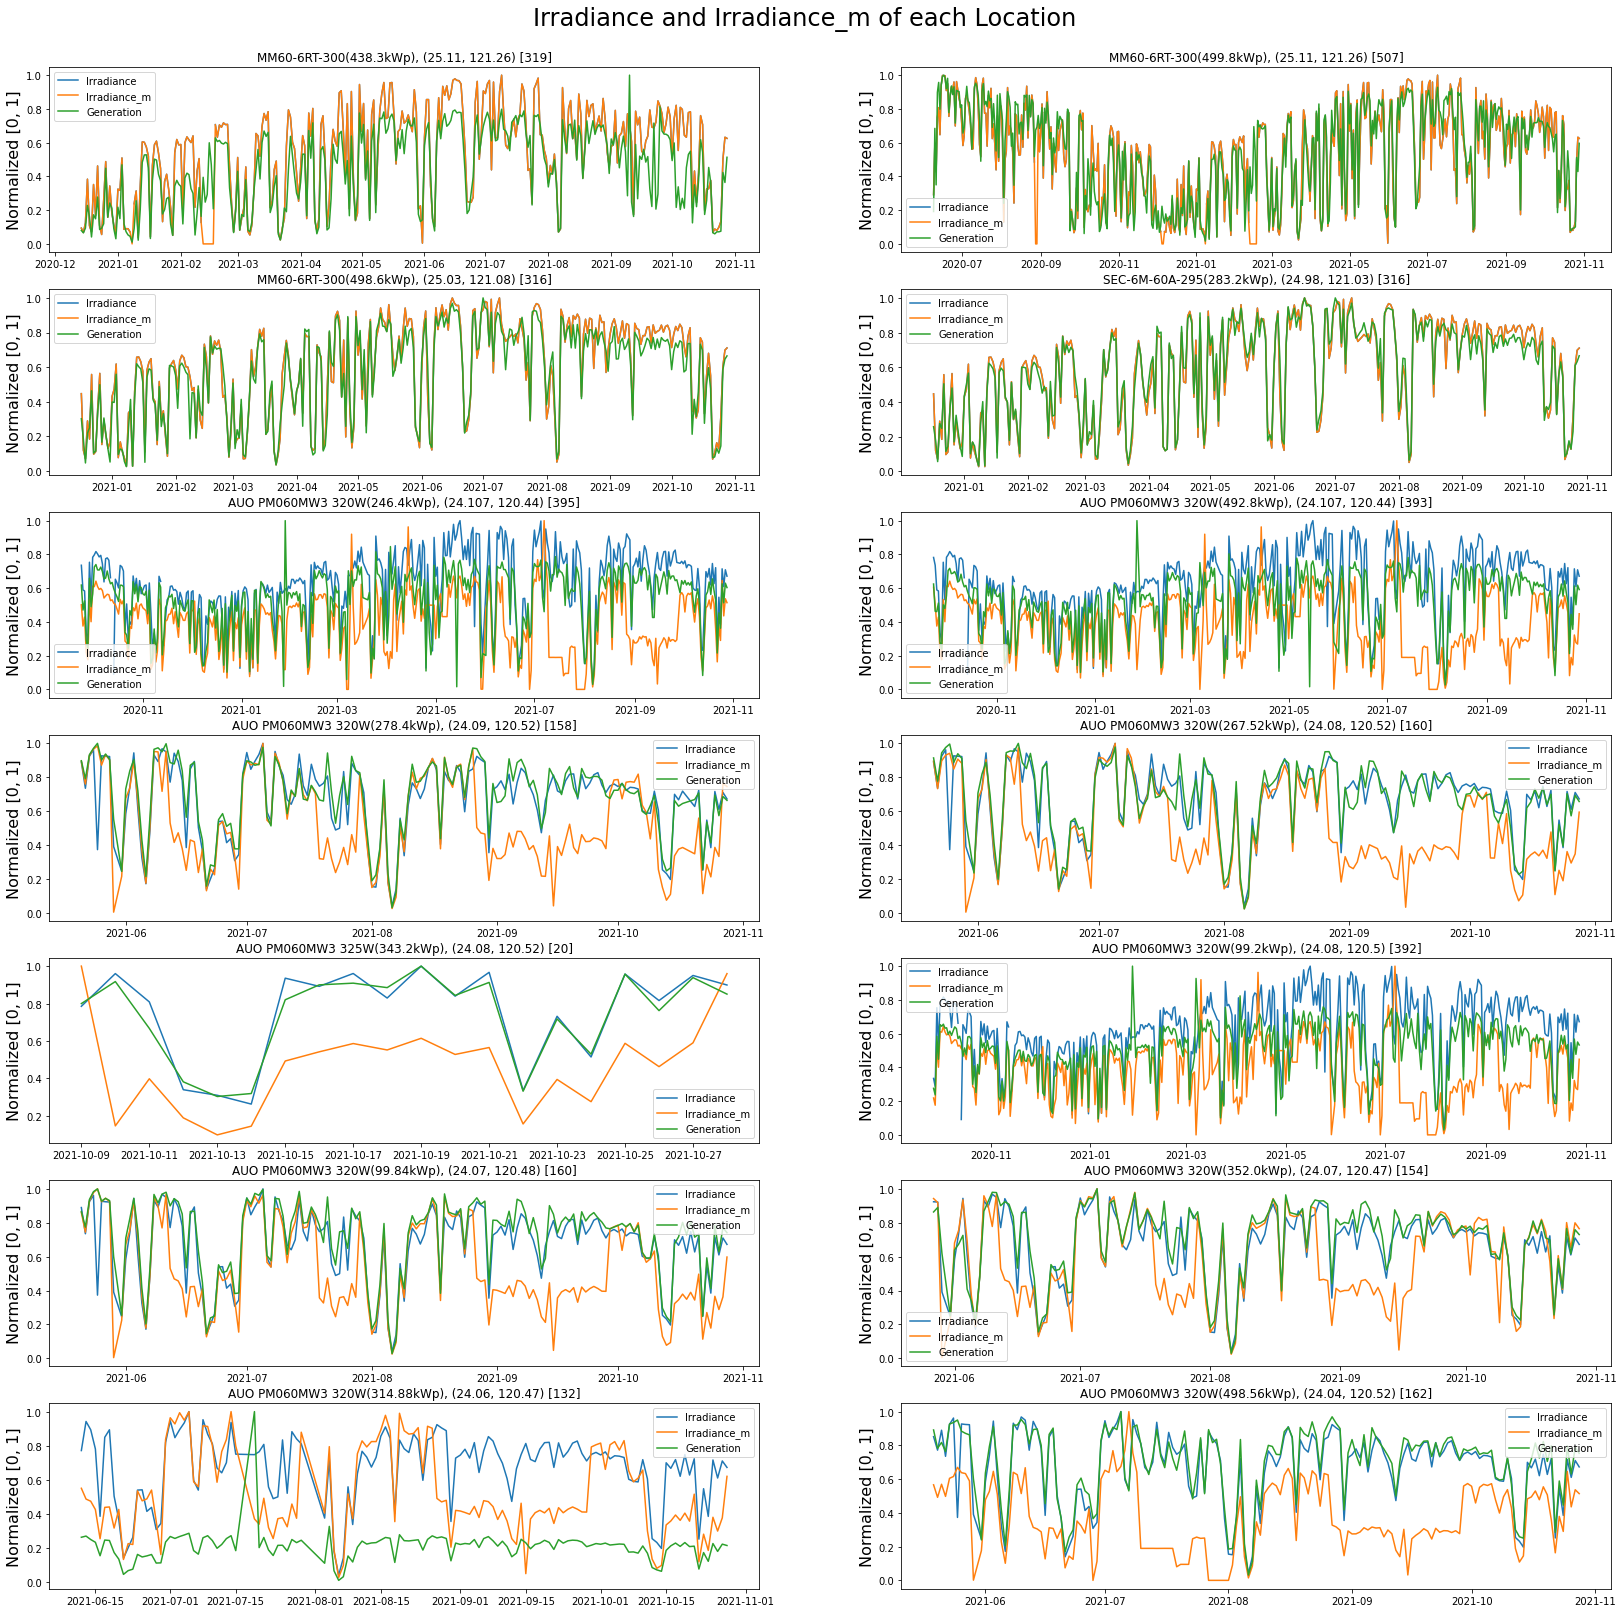

In [75]:
# 繪製每個案場在時間序列上 Irradiance、Irradiance_m 和 Generation 的變化趨勢圖，並對這三項特徵**進行 0–1 正規化（Normalization）**以便比較。
# drow Irradiance and Irradiance_m of each location
plt.figure(figsize=(28, 28))
plt.suptitle('Irradiance and Irradiance_m of each Location', fontsize=24, y=0.91)
for i, row in train_counts_module_capacity_location.iterrows():
    idf = train[train['Lat'].eq(row['Lat']) & train['Lon'].eq(row['Lon']) & train['Module'].eq(row['Module']) & train['Capacity'].eq(row['Capacity'])] # 過濾出該案場的歷史資料
    plt.subplot(math.ceil(len(train_counts_module_capacity_location)/2), 2, i+1) # 為每個案場（Module + Capacity + Lat + Lon）建立一個子圖
    plt.title(f"{row['Module']}({row['Capacity']}kWp), ({row['Lat']}, {row['Lon']}) [{len(idf)}]") # 顯示模組型號、容量、座標、筆數
    # plt.plot(idf['Date'], idf['Irradiance'], label='Irradiance')
    # plt.plot(idf['Date'], idf['Irradiance_m'], label='Irradiance_m')
    plt.plot(idf['Date'], idf['Irradiance']/idf['Irradiance'].max(), label='Irradiance') #  Max Normalization
    plt.plot(idf['Date'], idf['Irradiance_m']/idf['Irradiance_m'].max(), label='Irradiance_m') #  Max Normalization
    plt.plot(idf['Date'], idf['Generation']/idf['Generation'].max(), label='Generation') #  Max Normalization
    # plt.ylabel('kWh/m²', fontsize=16)
    plt.ylabel('Normalized [0, 1]', fontsize=16)
    plt.legend() # 顯示圖例：三條曲線對應三個欄位


## Analysis: Outlier

觀察異常值的發生位置，評估如何處理


### Find and Define Outlier by ArrayRatio

定義 ArrayRatio 超過各模組平均值 +0.5 或 -0.5 的列為異常值，移除異常值 69 筆 (1.9%)


MM60-6RT-300      ( 25.11, 121.26) [ 438.3kW] total: 319, outliers: 16
MM60-6RT-300      ( 25.11, 121.26) [ 499.8kW] total: 507, outliers: 19
MM60-6RT-300      ( 25.03, 121.08) [ 498.6kW] total: 316, outliers:  1
SEC-6M-60A-295    ( 24.98, 121.03) [ 283.2kW] total: 316, outliers:  0
AUO PM060MW3 320W (24.107, 120.44) [ 246.4kW] total: 395, outliers: 14
AUO PM060MW3 320W (24.107, 120.44) [ 492.8kW] total: 393, outliers: 10
AUO PM060MW3 320W ( 24.09, 120.52) [ 278.4kW] total: 158, outliers:  1
AUO PM060MW3 320W ( 24.08, 120.52) [267.52kW] total: 160, outliers:  1
AUO PM060MW3 325W ( 24.08, 120.52) [ 343.2kW] total:  20, outliers:  0
AUO PM060MW3 320W ( 24.08,  120.5) [  99.2kW] total: 392, outliers:  4
AUO PM060MW3 320W ( 24.07, 120.48) [ 99.84kW] total: 160, outliers:  1
AUO PM060MW3 320W ( 24.07, 120.47) [ 352.0kW] total: 154, outliers:  0
AUO PM060MW3 320W ( 24.06, 120.47) [314.88kW] total: 132, outliers:  1
AUO PM060MW3 320W ( 24.04, 120.52) [498.56kW] total: 162, outliers:  1


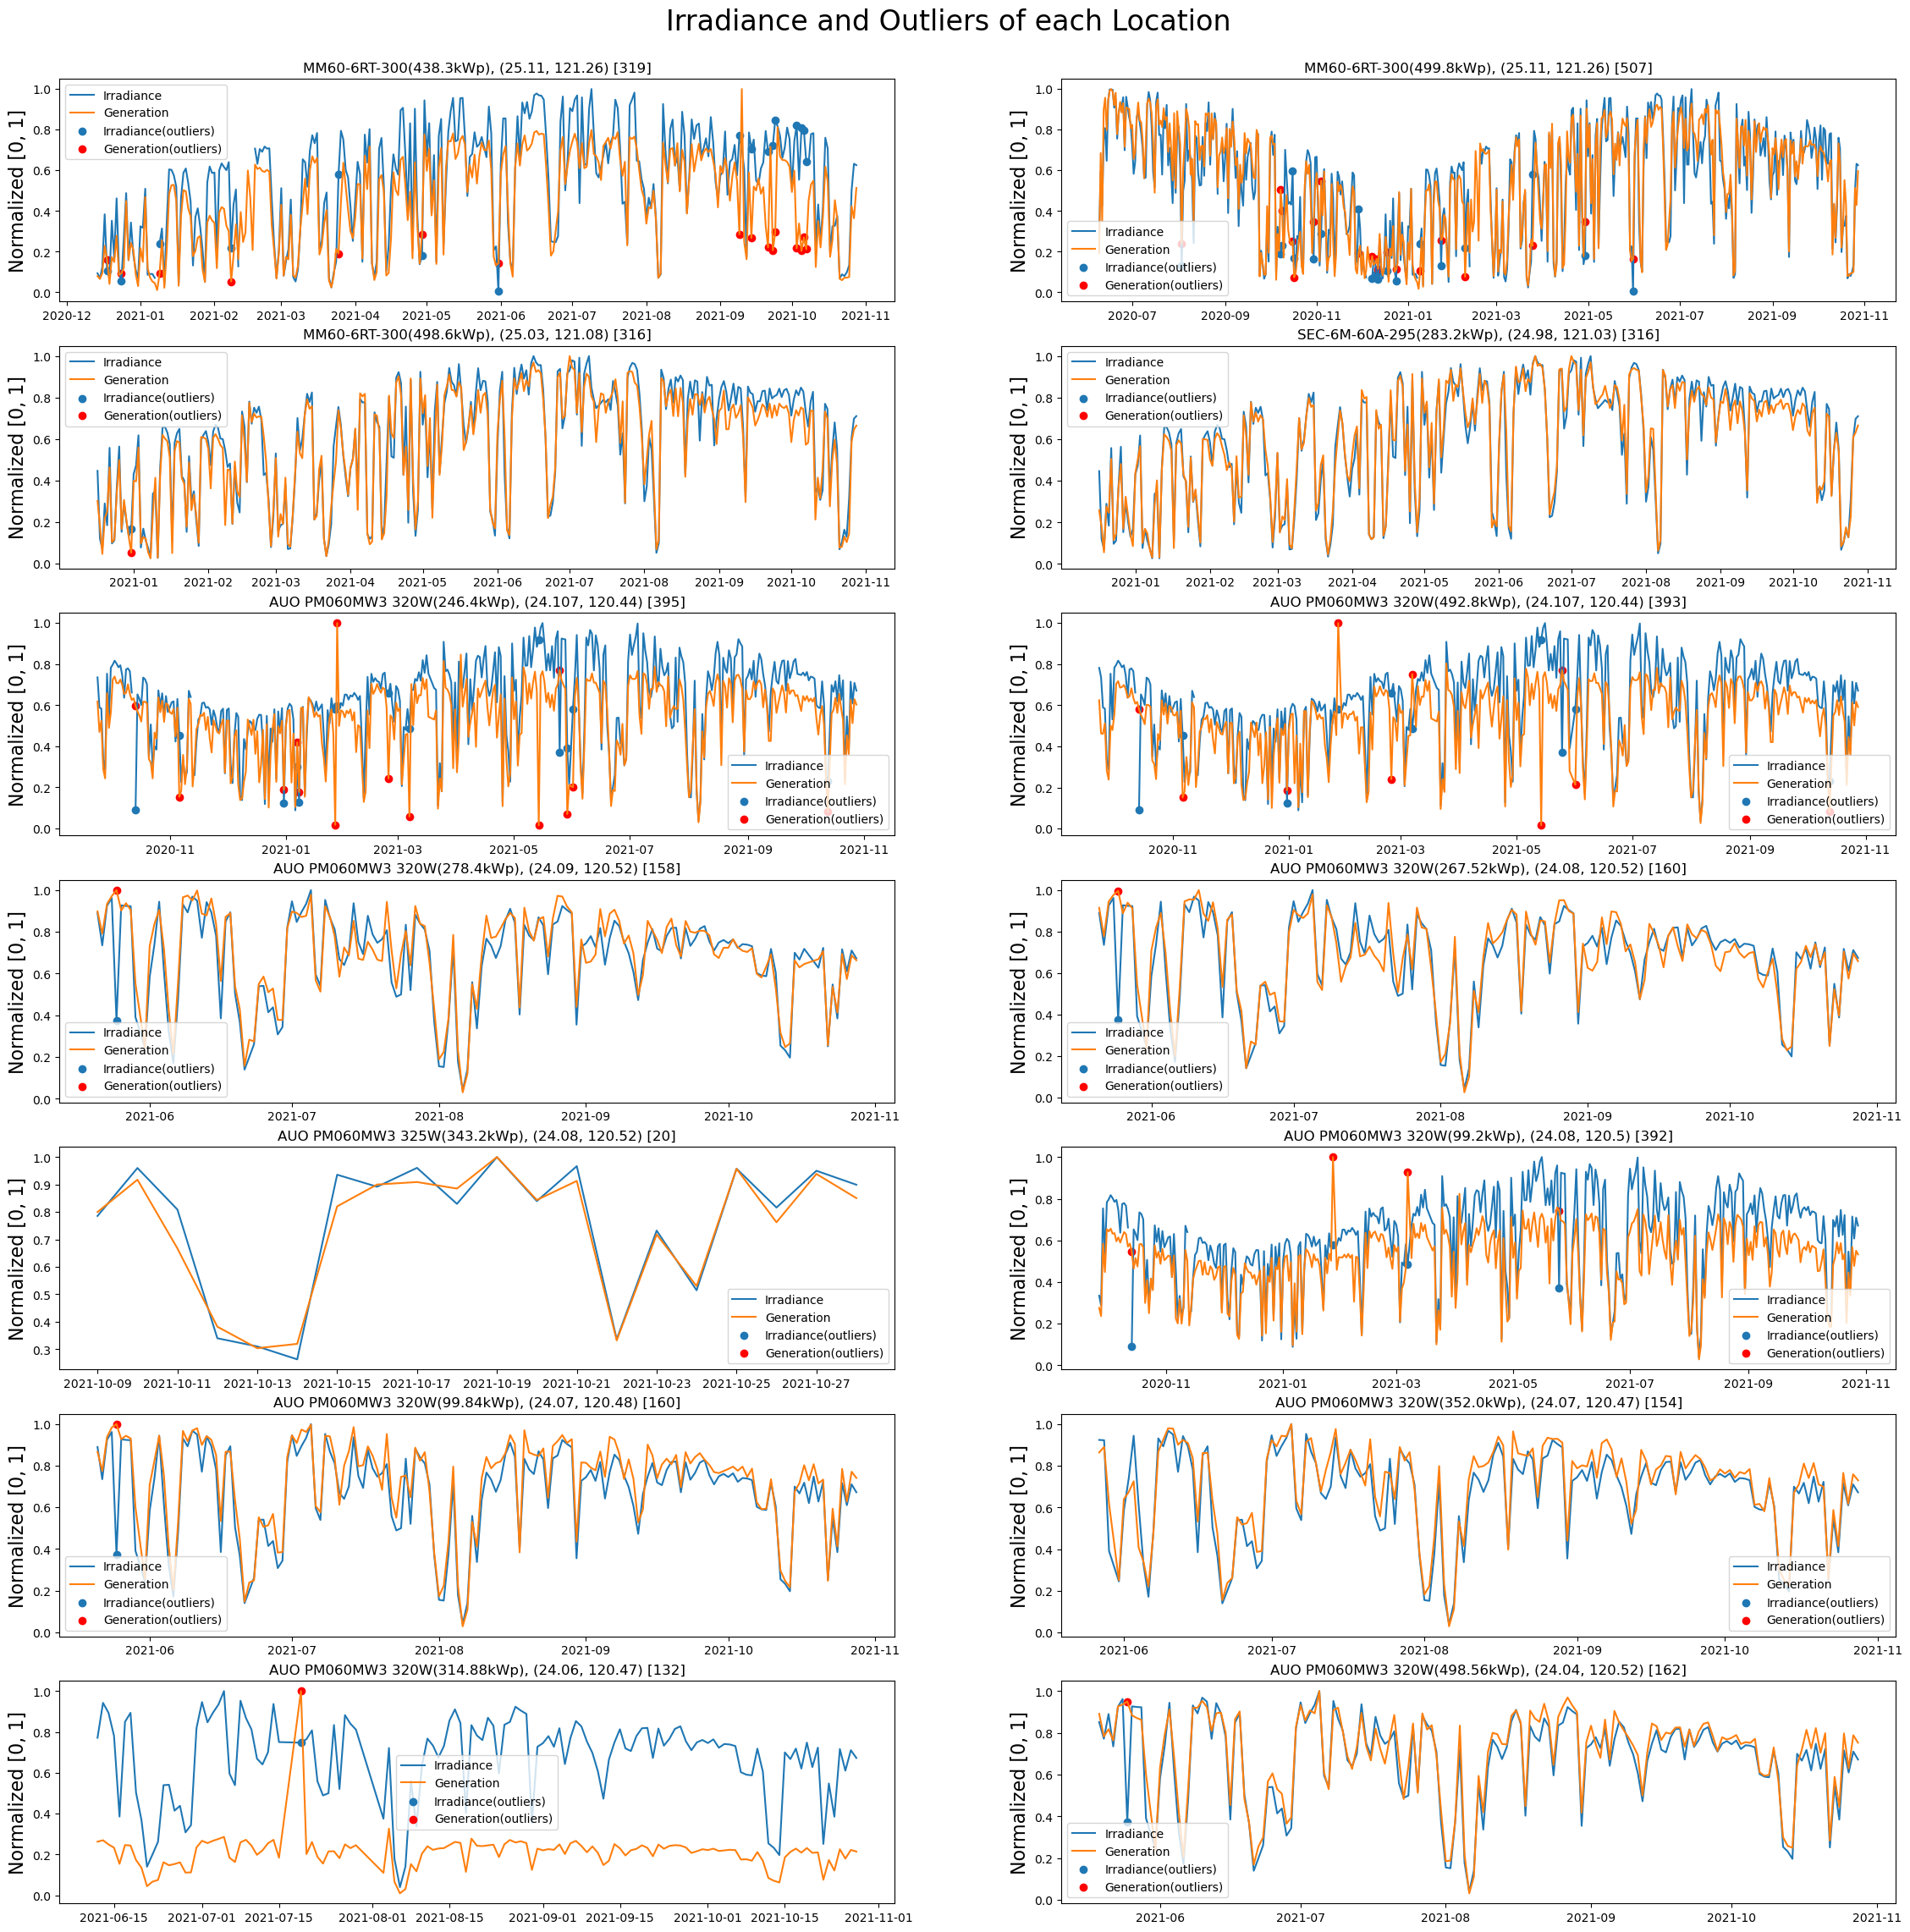

In [75]:
# 每個案場的異常值視覺化，根據 ArrayRatio 判斷哪些資料點為異常（outliers），並在 Irradiance 與 Generation 的時間序列圖上用散點標記出來。
plt.figure(figsize=(28, 28))
plt.suptitle('Irradiance and Outliers of each Location', fontsize=24, y=0.91)
for i, row in train_counts_module_capacity_location.iterrows():
    idf = train[train['Lat'].eq(row['Lat']) & train['Lon'].eq(row['Lon']) & train['Module'].eq(row['Module']) & train['Capacity'].eq(row['Capacity'])] # 每個案場資料子集
    outliers = idf[(idf['ArrayRatio'] > (row['ArrayRatio'] + 0.5)) | (idf['ArrayRatio'] < (row['ArrayRatio'] - 0.5))].index.tolist() # 判定異常值條件（以陣列轉換率 ArrayRatio 為中心 ± 0.5）
    print(F"{row['Module'].ljust(17)} ({str(row['Lat']).rjust(6)}, {str(row['Lon']).rjust(6)}) [{str(row['Capacity']).rjust(6)}kW]", F"total: {str(len(idf)).rjust(3)}, outliers: {str(len(outliers)).rjust(2)}")
    plt.subplot(math.ceil(len(train_counts_module_capacity_location)/2), 2, i+1)
    plt.title(f"{row['Module']}({row['Capacity']}kWp), ({row['Lat']}, {row['Lon']}) [{len(idf)}]")
    plt.plot(idf['Date'], idf['Irradiance']/idf['Irradiance'].max(), label='Irradiance')
    plt.plot(idf['Date'], idf['Generation']/idf['Generation'].max(), label='Generation')
    plt.scatter(idf[idf.index.isin(outliers)]['Date'], idf[idf.index.isin(outliers)]['Irradiance']/idf['Irradiance'].max(), label='Irradiance(outliers)')
    plt.scatter(idf[idf.index.isin(outliers)]['Date'], idf[idf.index.isin(outliers)]['Generation']/idf['Generation'].max(), c='r', label='Generation(outliers)')
    plt.ylabel('Normalized [0, 1]', fontsize=16)
    plt.legend() 

MM60-6RT-300      ( 25.11, 121.26) [ 438.3kW] total: 319, missing:  7
MM60-6RT-300      ( 25.11, 121.26) [ 499.8kW] total: 507, missing: 11
MM60-6RT-300      ( 25.03, 121.08) [ 498.6kW] total: 316, missing:  0
SEC-6M-60A-295    ( 24.98, 121.03) [ 283.2kW] total: 316, missing:  0
AUO PM060MW3 320W (24.107, 120.44) [ 246.4kW] total: 395, missing:  2
AUO PM060MW3 320W (24.107, 120.44) [ 492.8kW] total: 393, missing:  2
AUO PM060MW3 320W ( 24.09, 120.52) [ 278.4kW] total: 158, missing:  0
AUO PM060MW3 320W ( 24.08, 120.52) [267.52kW] total: 160, missing:  0
AUO PM060MW3 325W ( 24.08, 120.52) [ 343.2kW] total:  20, missing:  0
AUO PM060MW3 320W ( 24.08,  120.5) [  99.2kW] total: 392, missing:  2
AUO PM060MW3 320W ( 24.07, 120.48) [ 99.84kW] total: 160, missing:  0
AUO PM060MW3 320W ( 24.07, 120.47) [ 352.0kW] total: 154, missing:  0
AUO PM060MW3 320W ( 24.06, 120.47) [314.88kW] total: 132, missing:  0
AUO PM060MW3 320W ( 24.04, 120.52) [498.56kW] total: 162, missing:  0


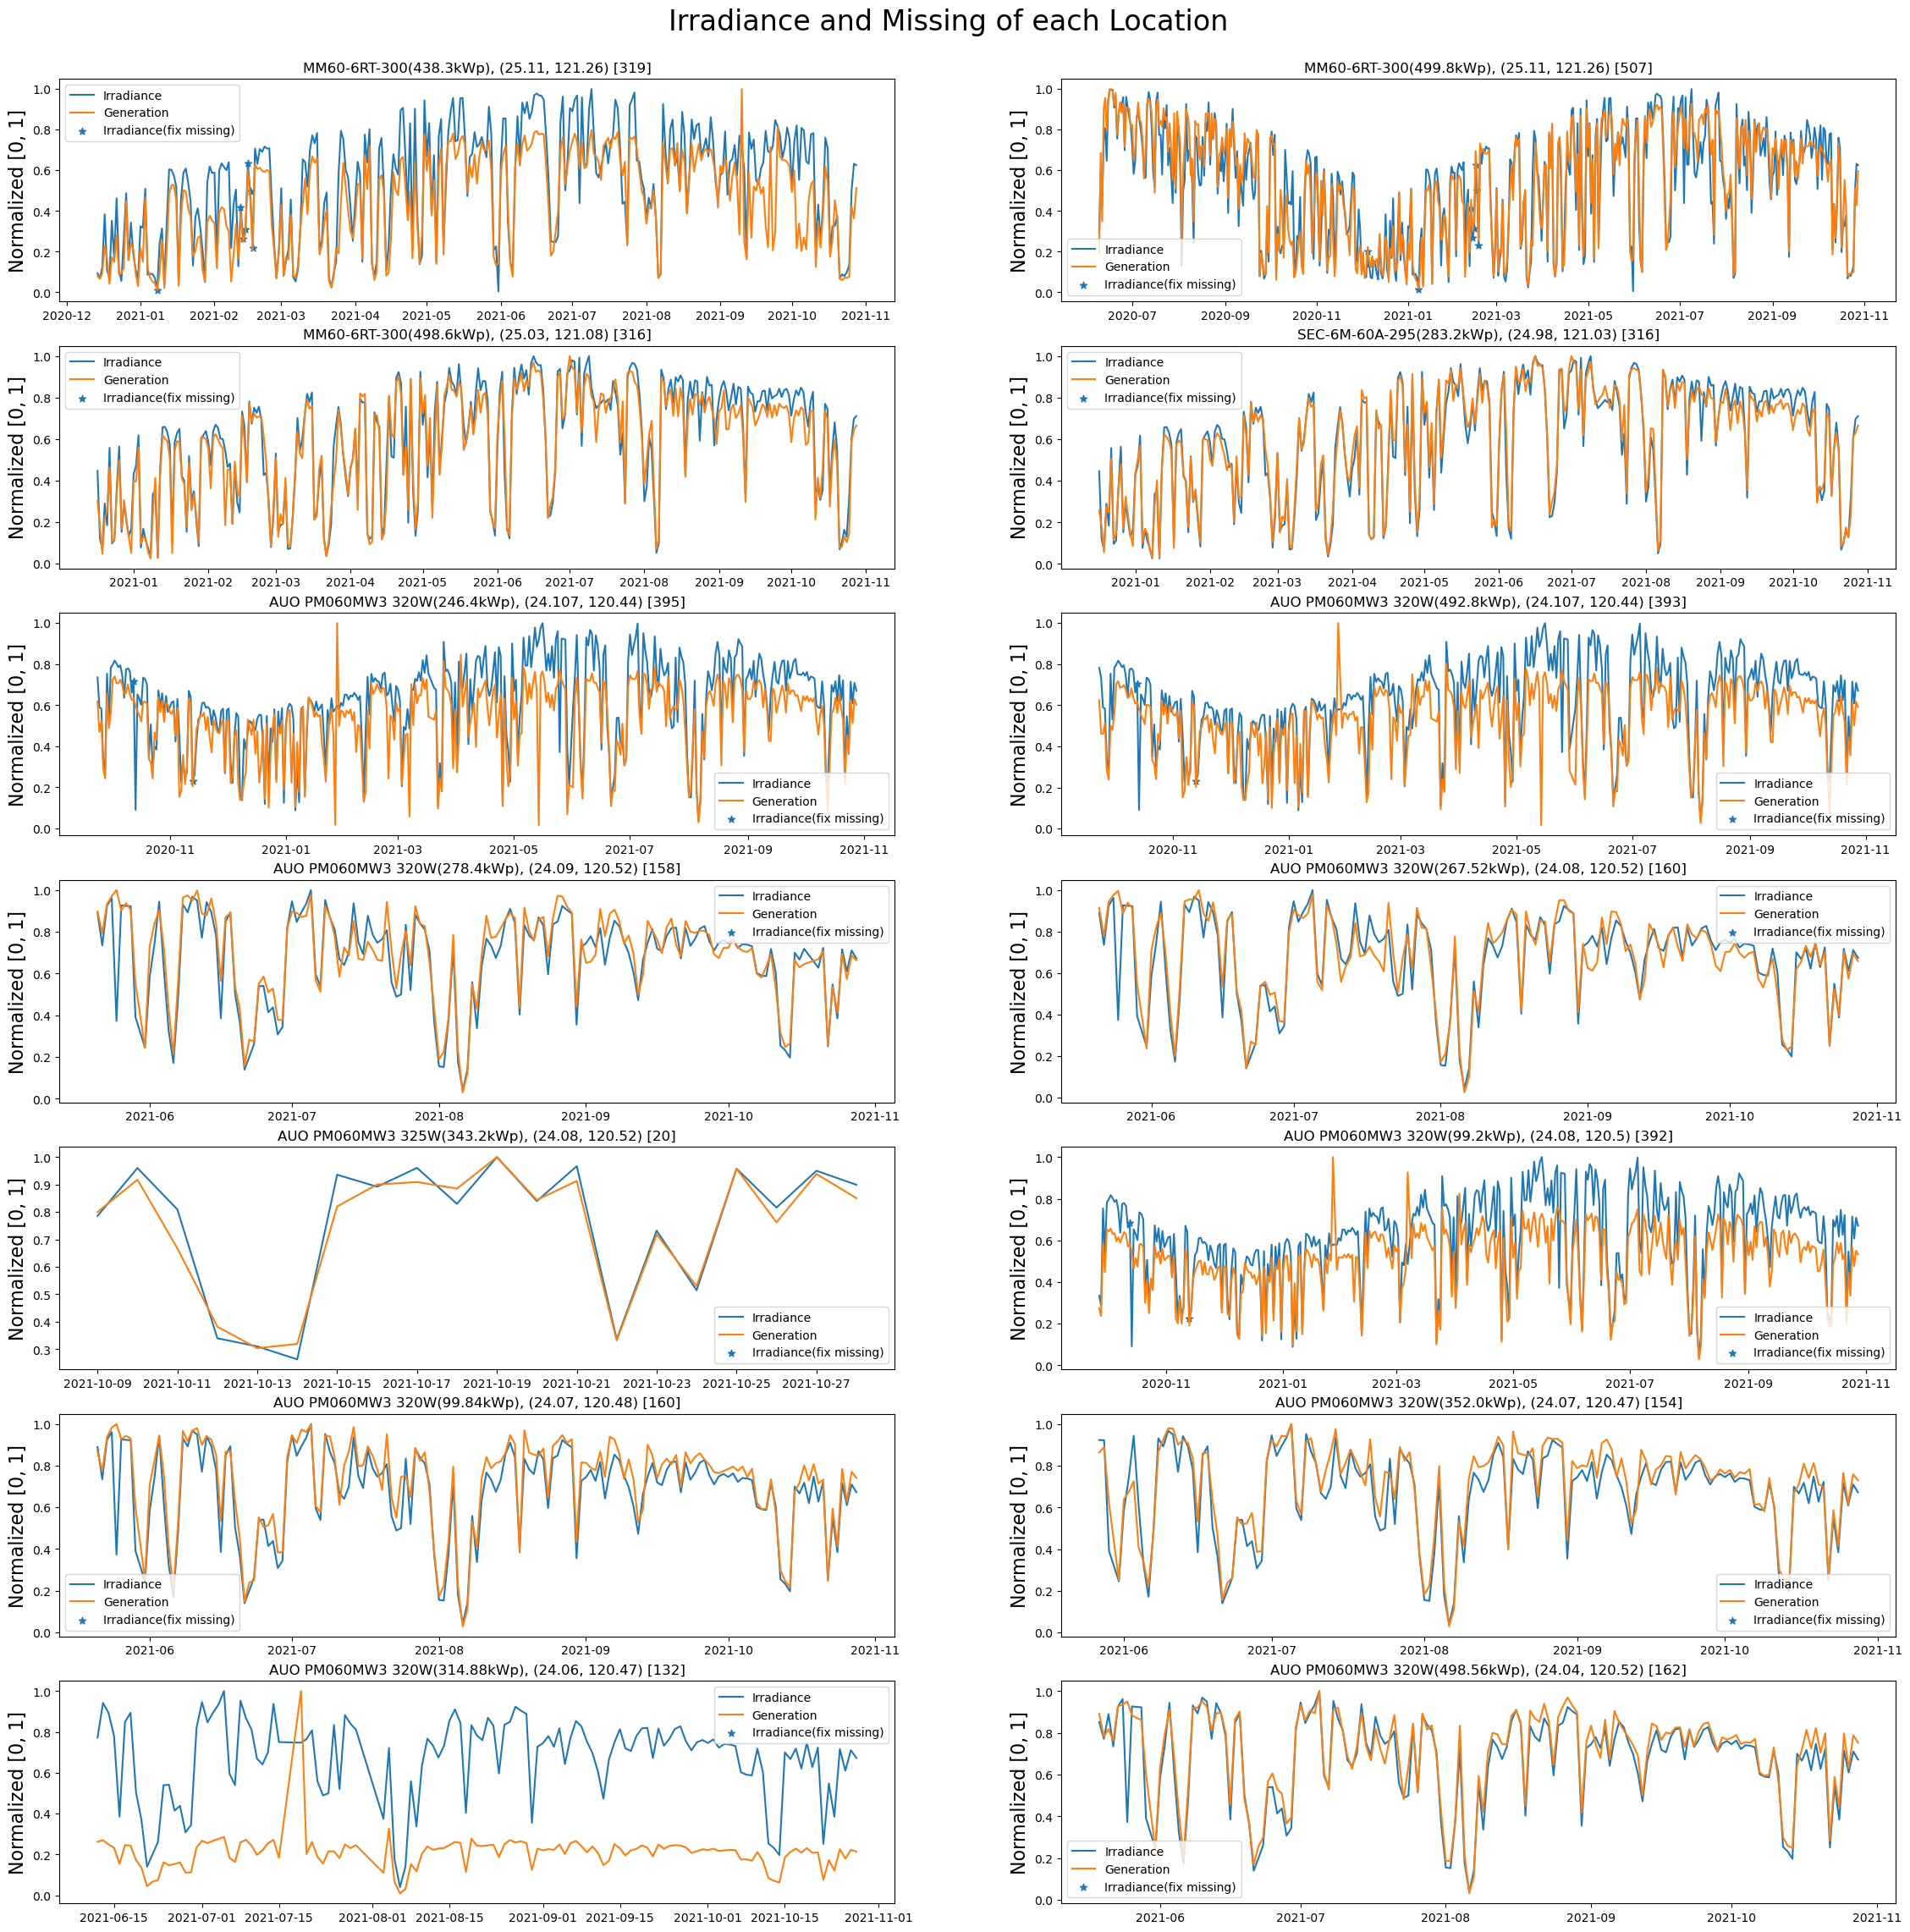

In [83]:
# 「缺失值補值 + 可視化」，目的是找出各案場中 Irradiance 缺失的位置，並用反推公式補上後進行視覺呈現。
plt.figure(figsize=(28, 28))
plt.suptitle('Irradiance and Missing of each Location', fontsize=24, y=0.91)
for i, row in train_counts_module_capacity_location.iterrows():
    idf = train[train['Lat'].eq(row['Lat']) & train['Lon'].eq(row['Lon']) & train['Module'].eq(row['Module']) & train['Capacity'].eq(row['Capacity'])]
    # outliers = idf[(idf['ArrayRatio'] > (row['ArrayRatio'] + 0.5)) | (idf['ArrayRatio'] < (row['ArrayRatio'] - 0.5))].index.tolist()
    missing = idf[idf['Irradiance'].isna()].index.tolist()
    
    idf.loc[missing, 'Irradiance'] = train.loc[missing, 'Generation'] / row['ArrayRatio'] / row['Capacity'] # 補值公式：Irradiance ≈ Generation / (ArrayRatio × Capacity)
    
    print(F"{row['Module'].ljust(17)} ({str(row['Lat']).rjust(6)}, {str(row['Lon']).rjust(6)}) [{str(row['Capacity']).rjust(6)}kW]", F"total: {str(len(idf)).rjust(3)}, missing: {str(len(missing)).rjust(2)}")
    plt.subplot(math.ceil(len(train_counts_module_capacity_location)/2), 2, i+1)
    plt.title(f"{row['Module']}({row['Capacity']}kWp), ({row['Lat']}, {row['Lon']}) [{len(idf)}]")
    plt.plot(idf['Date'], idf['Irradiance']/idf['Irradiance'].max(), label='Irradiance')
    plt.plot(idf['Date'], idf['Generation']/idf['Generation'].max(), label='Generation')
    # plt.scatter(idf[idf.index.isin(missing)]['Date'], idf[idf.index.isin(missing)]['Irradiance']/idf['Irradiance'].max(), label='Irradiance(outliers)')
    plt.scatter(idf[idf.index.isin(missing)]['Date'], idf[idf.index.isin(missing)]['Irradiance']/idf['Irradiance'].max(), marker='*', label='Irradiance(fix missing)')
    plt.ylabel('Normalized [0, 1]', fontsize=16)
    plt.legend() 